# CML processing with radar wet-dry

In [39]:
import sys
import os
sys.path.append(os.path.abspath("../poligrain/src"))
sys.path.append(os.path.abspath("../mergeplg/src"))
sys.path.append(os.path.abspath("../pycomlink/"))


import poligrain as plg
import mergeplg as mrg
import pycomlink as pycml

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

## 1. Radar wet dry

In [40]:
# Fetches 8 days from OpenMRG dataset
(
    ds_rad,
    ds_cmls,
    ds_gauges_municp,
    ds_gauge_smhi,
) = plg.example_data.load_openmrg(data_dir="example_data", subset="8d")

ds_cmls = ds_cmls.rename_vars({'R': 'R_example'})
ds_rad = ds_rad.rename({'R':'rainfall_radar'})

File already exists at example_data/openmrg_cml_8d.nc
Not downloading!
File already exists at example_data/openmrg_rad_8d.nc
Not downloading!
File already exists at example_data/openmrg_municp_gauge_8d.nc
Not downloading!
File already exists at example_data/openmrg_smhi_gauge_8d.nc
Not downloading!


In [41]:
# Project data to coordinate system
# UTM32N: https://epsg.io/32632
ref_str = "EPSG:32632"

ds_gauges_municp.coords["x"], ds_gauges_municp.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges_municp.lon, ds_gauges_municp.lat, ref_str
)

# For CML
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, ref_str
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, ref_str
)

# Midpoint
ds_cmls.coords["x"] = (ds_cmls.site_0_x + ds_cmls.site_1_x) / 2
ds_cmls.coords["y"] = (ds_cmls.site_0_y + ds_cmls.site_1_y) / 2


# Projected radar coords
ds_rad.coords["x_grid"], ds_rad.coords["y_grid"] = (
    plg.spatial.project_point_coordinates(ds_rad.lon, ds_rad.lat, ref_str)
)

### CML preprocessing 

In [42]:
# Select time window for preprocessing
start = "2015-07-25T06:00"
end = "2015-07-25T21:00"
ds_cmls = ds_cmls.sel(time = slice(start, end)).load() # load() speeds up calculations

# Select sublink 0
ds_cmls = ds_cmls.isel(sublink_id = 0)

# Resample CML dataset to 1 minute resolution
ds_cmls = ds_cmls.resample(time = "1min").first(skipna=True)

# calculate total loss
ds_cmls["tl"] = ds_cmls.tsl - ds_cmls.rsl

# Interpolate na
ds_cmls['tl'] = ds_cmls.tl.interpolate_na(dim='time', method='linear', max_gap='5min')

# flag cmls with strong diurnal fluctuation
qc_diurnalcicle = (ds_cmls.tl.rolling(time=60 * 5, center=True).std() > 2).mean(dim="time") > 0.1

# flag cmls with very noisy periods
qc_noisyperiods = (ds_cmls.tl.rolling(time=60, center=True).std() > 0.8).mean(dim="time") > 0.20

ds_cmls.where(qc_diurnalcicle, drop=True);
ds_cmls.where(qc_noisyperiods, drop=True);

### Reduce dataset to just a few CMLs


In [43]:
ds_cmls = ds_cmls.isel(cml_id = [0, 50, 100])

### Wet dry/detection using radar and rolling standard deviation

In [44]:
# RSD wet/Dry for reference
ds_cmls["wet_rsd"] = ds_cmls.tl.rolling(time=60, center=True).std(skipna=False) > 0.8

# Quantile rsd
roll_std_dev = ds_cmls.tl.rolling(time=60, center=True).std()
threshold = 1.12 * roll_std_dev.quantile(0.8, dim="time")
ds_cmls["wet_quantile"] = roll_std_dev > threshold

In [45]:
# Create another xarray object for CML time sereis using radar
ds_cmls_rad = ds_cmls.copy()

In [74]:
# Estimate radar along CML
grid_at_lines = plg.spatial.GridAtLines(ds_rad, ds_cmls_rad)

# Radar rainfall rates along CML
da_radar_along_cmls = grid_at_lines(ds_rad.rainfall_radar)

# Set wet periods above threshold
ds_cmls_rad['wet']  = (da_radar_along_cmls > 0.1).rolling(time=3, center=True).max()

### CML processing using radar wet

In [9]:
# Estimate the baseline during rain events
ds_cmls_rad["baseline"] = pycml.processing.baseline.baseline_constant(
    trsl=ds_cmls_rad.tl,
    wet=ds_cmls_rad.wet,
    n_average_last_dry=5,
)

# compenmsate for wet antenna attenuation
ds_cmls_rad["A_obs"] = ds_cmls_rad.tl - ds_cmls_rad.baseline
ds_cmls_rad["A_obs"] = ds_cmls_rad.A_obs.where(ds_cmls_rad.A_obs >= 0, 0)
ds_cmls_rad["waa"] = pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs(
    A_obs=ds_cmls_rad.A_obs,
    f_Hz=ds_cmls_rad.frequency * 1e6,
    pol=ds_cmls_rad.polarization.data,
    L_km=ds_cmls_rad.length / 1000,
    A_max=6,
    zeta=0.7,  # 0.55 is default
    d=0.15, # 
)


# calculate attenuation caused by rain and remove negative attenuation
ds_cmls_rad["A"] = ds_cmls_rad.tl - ds_cmls_rad.baseline - ds_cmls_rad.waa
ds_cmls_rad["A"].data[ds_cmls_rad.A < 0] = 0
# derive rain rate via the k-R relation
ds_cmls_rad["R"] = pycml.processing.k_R_relation.calc_R_from_A(
    A=ds_cmls_rad.A,
    L_km=ds_cmls_rad.length.astype(float) / 1000,  # convert to km
    f_GHz=ds_cmls_rad.frequency / 1000,  # convert to GHz
    pol=ds_cmls_rad.polarization,
)


### CML processing using RSD

In [10]:
# Estimate the baseline during rain events
ds_cmls["baseline"] = pycml.processing.baseline.baseline_constant(
    trsl=ds_cmls.tl,
    wet=ds_cmls.wet_rsd,
    n_average_last_dry=5,
)

# compenmsate for wet antenna attenuation
ds_cmls["A_obs"] = ds_cmls.tl - ds_cmls.baseline
ds_cmls["A_obs"] = ds_cmls.A_obs.where(ds_cmls.A_obs >= 0, 0)
ds_cmls["waa"] = pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs(
    A_obs=ds_cmls.A_obs,
    f_Hz=ds_cmls.frequency * 1e6,
    pol=ds_cmls.polarization.data,
    L_km=ds_cmls.length / 1000,
    A_max=6,
    zeta=0.7,  # 0.55 is default
    d=0.15, # 
)


# calculate attenuation caused by rain and remove negative attenuation
ds_cmls["A"] = ds_cmls.tl - ds_cmls.baseline - ds_cmls.waa
ds_cmls["A"].data[ds_cmls.A < 0] = 0
# derive rain rate via the k-R relation
ds_cmls["R"] = pycml.processing.k_R_relation.calc_R_from_A(
    A=ds_cmls.A,
    L_km=ds_cmls.length.astype(float) / 1000,  # convert to km
    f_GHz=ds_cmls.frequency / 1000,  # convert to GHz
    pol=ds_cmls.polarization,
)


### Plot time series of one CML

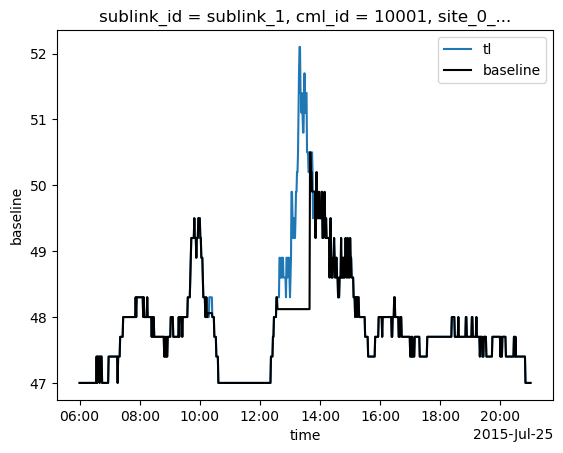

In [11]:
# RSD wet/dry detection
cml_i = 0
ds_cmls.isel(cml_id = cml_i).tl.plot(color = 'C0', label='tl')
ds_cmls.isel(cml_id = cml_i).baseline.plot(color = 'k', label='baseline')
plt.legend()

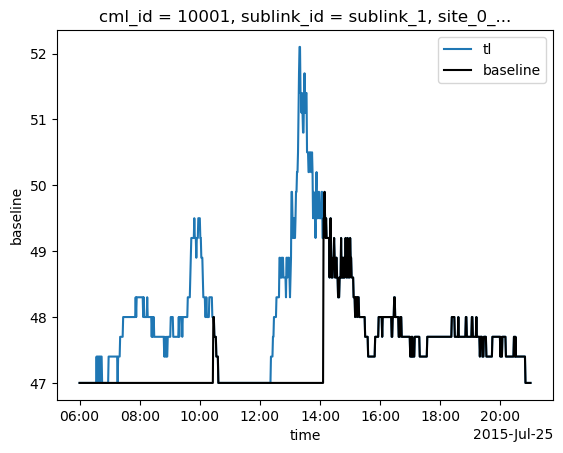

In [12]:
# Radar wet/dry detection
cml_i = 0
ds_cmls_rad.isel(cml_id = cml_i).tl.plot(color = 'C0', label='tl')
ds_cmls_rad.isel(cml_id = cml_i).baseline.plot(color = 'k', label='baseline')
plt.legend()

## Exercises 1.

1. Improve the RSD based baseline estimate, by tuning the threshold value.
2. Use the quantile based wet/dry periods to estimate the baseline.
3. A challenge with wet/dry detection methods is that short dry breaks can occur during rainy events. Use a rolling window to extend wet periods in both forward and backward in time.

### Hints 1.

- To tune the RSD based threshold, change the constant on the right side of RSD wet/Dry code above
- You could also use the quantile approach, see code above.
- The following code does a rolling centered window sum of the data: "(ds_cmls_rad.isel(cml_id = 0).wet.rolling(time = 20, center=True).sum() > 0).plot()". If there is any rainfall inside the window, the the period wil be set to wet. 


# 2. Interpolate rainfall maps

## 2.1 Prepare example data from poligrain

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append(os.path.abspath("../poligrain/src"))
sys.path.append(os.path.abspath("../mergeplg/src"))
sys.path.append(os.path.abspath("../pycomlink/"))


import poligrain as plg
import mergeplg as mrg
import pycomlink as pycml

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Fetches 8 days from OpenMRG dataset
(
    ds_rad,
    ds_cmls,
    ds_gauges_municp,
    ds_gauge_smhi,
) = plg.example_data.load_openmrg(data_dir="example_data", subset="8d")

ds_rad = ds_rad.rename({'R':'rainfall_radar'})

File already exists at example_data/openmrg_cml_8d.nc
Not downloading!
File already exists at example_data/openmrg_rad_8d.nc
Not downloading!
File already exists at example_data/openmrg_municp_gauge_8d.nc
Not downloading!
File already exists at example_data/openmrg_smhi_gauge_8d.nc
Not downloading!


In [4]:
# Project data to coordinate system
# UTM32N: https://epsg.io/32632
ref_str = "EPSG:32632"

ds_gauges_municp.coords["x"], ds_gauges_municp.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges_municp.lon, ds_gauges_municp.lat, ref_str
)

# For CML
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, ref_str
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, ref_str
)

# Midpoint
ds_cmls.coords["x"] = (ds_cmls.site_0_x + ds_cmls.site_1_x) / 2
ds_cmls.coords["y"] = (ds_cmls.site_0_y + ds_cmls.site_1_y) / 2


# Projected radar coords
ds_rad.coords["x_grid"], ds_rad.coords["y_grid"] = (
    plg.spatial.project_point_coordinates(ds_rad.lon, ds_rad.lat, ref_str)
)

In [5]:
# Reduce dataset, selecting 1 hour of data
start = "2015-07-25T13:00"
end = "2015-07-25T14:00"
ds_rad = ds_rad.sel(time = slice(start, end)).load() 
ds_cmls = ds_cmls.sel(time = slice(start, end)).load() 
ds_gauges_municp = ds_gauges_municp.sel(time = slice(start, end)).load() 
ds_gauge_smhi = ds_gauge_smhi.sel(time = slice(start, end)).load() 

In [6]:
# Select sublink 0
ds_cmls = ds_cmls.isel(sublink_id = 0)

# Resample CML dataset to 1 minute resolution
ds_cmls = ds_cmls.resample(time = "1min").first(skipna=True)

### Resample observations to common time resolution

In [7]:
# Resample units of reference data to common 15 minute resolution
da_rad_15_min = (ds_rad.rainfall_radar*5/60).resample(time = '15min', label='right', closed='right').sum() # from mm/h -> sum 5min
da_gauges_municp_15min = ds_gauges_municp.rainfall_amount.resample(time="15min", label='right', closed='right').sum() # from sum 1min -> sum 15min 
da_gauge_smhi_15min = ds_gauge_smhi.rainfall_amount # Already at correct resolution
da_cmls_15min = (ds_cmls.R/60).resample(time = '15min', label='right', closed='right').sum() # from mm/h -> sum 5min

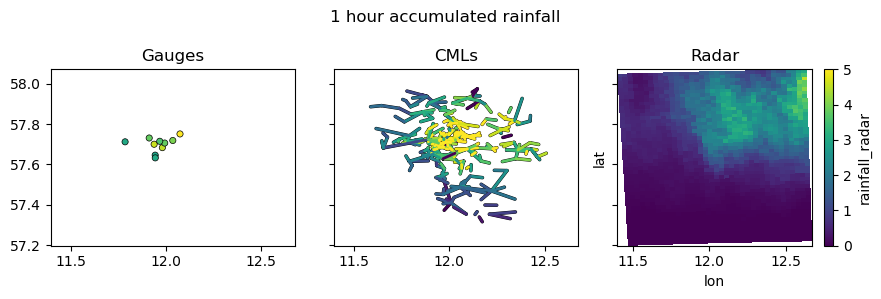

In [8]:
# Plot situation and check that the processed data is similar to example data
fig, ax = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

plg.plot_map.plot_plg(
    da_gauges=da_gauges_municp_15min.sum(dim="time"),
    use_lon_lat=True,
    vmin=0,
    vmax=5,
    cmap = 'viridis',
    ax=ax[0]
)
plg.plot_map.plot_plg(
    use_lon_lat=True,
    da_cmls=da_cmls_15min.sum(dim = 'time'),
    vmin=0,
    vmax=5,
    cmap = 'viridis',
    ax=ax[1]
)
plg.plot_map.plot_plg(
    da_grid=da_rad_15_min.sum(dim="time"),
    #da_gauges=da_gauges_municp_15min.sum(dim="time"),
    use_lon_lat=True,
    vmin=0,
    vmax=5,
    cmap = 'viridis',
    ax=ax[2]
)
ax[0].set_title('Gauges')
ax[1].set_title('CMLs')
ax[2].set_title('Radar')
fig.suptitle('1 hour accumulated rainfall')
fig.tight_layout()

### Zoom in radar and CML to area around rain gauges


In [9]:
offset = 4000 # meter
x_min = da_gauges_municp_15min.x.min() - offset
x_max = da_gauges_municp_15min.x.max() + offset
y_min = da_gauges_municp_15min.y.min() - offset
y_max = da_gauges_municp_15min.y.max() + offset

# Select small area radar
da_rad_small = da_rad_15_min.isel(
    x = np.where((da_rad_15_min.x_grid < x_max).any(dim='y') & (da_rad_15_min.x_grid > x_min).any(dim='y'))[0],
    y = np.where((da_rad_15_min.y_grid < y_max).any(dim='x') & (da_rad_15_min.y_grid > y_min).any(dim='x'))[0],
)

# Select small area CML
da_cmls_small = da_cmls_15min.isel(cml_id = np.where(
        (da_cmls_15min.site_0_x < x_max) & (da_cmls_15min.site_1_x < x_max) & 
        (da_cmls_15min.site_0_x > x_min) & (da_cmls_15min.site_1_x > x_min) & 
        (da_cmls_15min.site_0_y < y_max) & (da_cmls_15min.site_1_y < y_max) & 
        (da_cmls_15min.site_0_y > y_min) & (da_cmls_15min.site_1_y > y_min)
    )[0]
)

# Select CMLs longer than 4000 meter
da_cmls_small = da_cmls_small.isel(cml_id = np.where(da_cmls_small.length > 4000)[0])

# Select 3 CMLs of subset
da_cmls_small = da_cmls_small.isel(cml_id = [0, 10, 15])

# Select rain gauges
da_gauges_small = da_gauges_municp_15min

<Axes: >

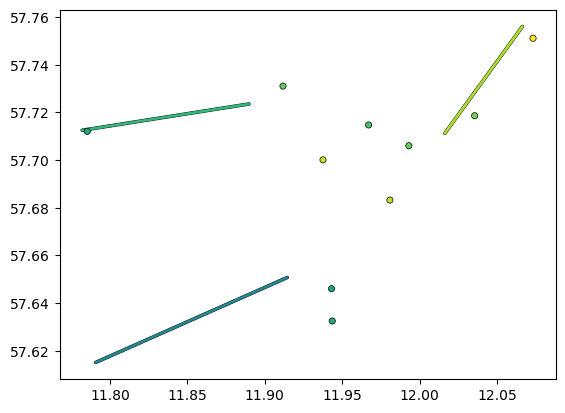

In [10]:
# Plot situation and check that the processed data is similar to example data
plg.plot_map.plot_plg(
    #da_grid=da_rad_small.sum(dim="time"),
    da_gauges=da_gauges_small.sum(dim="time"),
    da_cmls=da_cmls_small.sum(dim = 'time'),
    use_lon_lat=True,
    vmin=0,
    vmax=5,
    cmap = 'viridis',
)



## 2.2 Interpolate rainfall maps
We often want to know the rainfall rates at places where we do not have observations.

### IDW - Inverse distance weighting


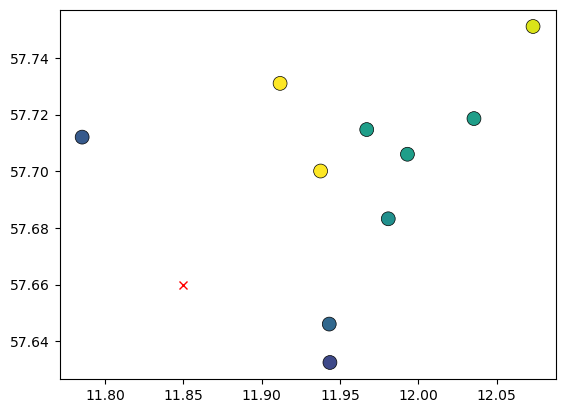

In [11]:
# Plot situation and check that the processed data is similar to example data
t = 3
plg.plot_map.plot_plg(
    da_gauges=da_gauges_municp_15min.isel(time = t),
    use_lon_lat=True,
    vmin=0,
    marker_size=100,# size of dots
    cmap = 'viridis'
)
plt.plot(11.85, 57.66, 'rx')

Want to know the value at the red x in the plot above? Inverse distance weights works by applying weights $\tilde{w_i}$ to the observations $Z(x_i)$ so that close observations are weighted more
$$
Z(x) = \sum_{i=1}^{n} \tilde{w_i} \cdot Z(x_i)
$$

$$
\tilde{w_i} = \frac{w_i}{\sum_{j=1}^{n} w_j}
$$

where

$$
w_i = d(x, x_i)^{-p}
$$

$$
d(x, x_i) = \sqrt{(x - x_i)^2 + (y - y_i)^2}
$$

#### IDW using mergeplg

In [12]:
# Import interpolator
interpolator = mrg.interpolate.InterpolateIDW(min_observations=1)

# Interpolate several timesteps
rainfall_field = []
for time in da_gauges_small.time.data:
    rainfall_field.append(
        # Interpolate 1 timestep
        interpolator.interpolate(
            da_grid = da_rad_small.sel(time = [time]), # Use radar grid coordinates for interpolation
            da_gauge = da_gauges_small.sel(time = [time]), # Data to interpolate, here rain gauges
            p=100, # IDW parameter
            nnear=20, # IDW number of nearest observations to use
        )
    )

# Concat resulting fields
interpolate_idw = xr.concat(rainfall_field, dim="time")

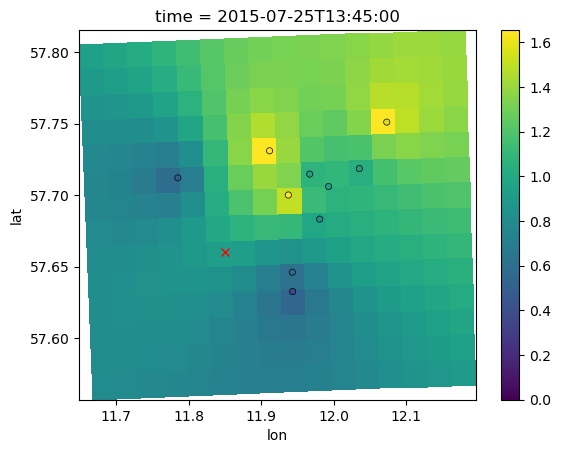

In [13]:
# Plot interpolated field
t = 3
plg.plot_map.plot_plg(
    da_grid=interpolate_idw.isel(time = t),
    da_gauges=da_gauges_municp_15min.isel(time = t),
    use_lon_lat=True,
    vmin=0,
    marker_size=20,
    cmap='viridis'
)
plt.plot(11.85, 57.66, 'rx')

### Exercises IDW
- Set nnear to 2, what happens?
- Include CMLs in the map. Hint: Run "interpolator.interpolate?" to see how you can supply CML data to mergeplg.
- Play around with the p-parameter, how does p affect your results? 

## Kriging

### Introduction to Ordinary Kriging

Ordinary Kriging is a geostatistical method used to predict the value of a variable at an unsampled location based on spatial correlation. The key components of Kriging include the variogram, Kriging weights, and the prediction formula.

### Variogram

The variogram $\gamma(h)$ is a function that describes the degree of spatial dependence between samples. It is defined as:

$$
\gamma(h) = \frac{1}{2} \mathrm{Var} \left[ Z(x) - Z(x+h) \right]
$$

where $h$ is the lag distance between two points $x$ and $x+h$.

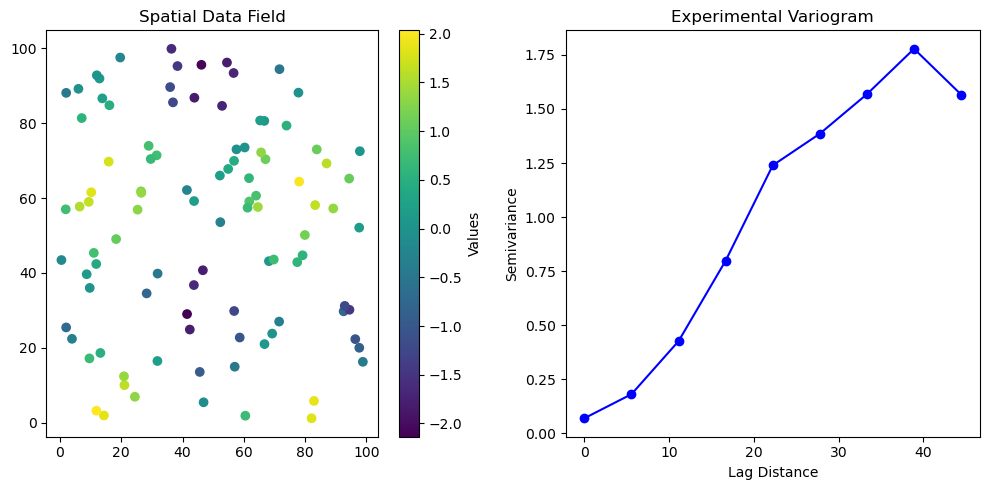

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

# Generate coordinates
np.random.seed(0)
n_points = 100
h_range = 10 # spatial correlation
x_coords = np.random.uniform(0, 100, n_points)
y_coords = np.random.uniform(0, 100, n_points)

# Spatial function with some noise
values = np.sin(x_coords / h_range) + np.cos(y_coords / h_range) + np.random.normal(0, 0.2, n_points)

# Compute pairwise distances and variogram
distances = pdist(np.column_stack((x_coords, y_coords)))
semivariances = pdist(values[:, None], metric='sqeuclidean') / 2

# Define lag bins and compute average semivariance per bin
lags = np.linspace(0, 50, 10)
bin_indices = np.digitize(distances, bins=lags)
avg_semivariances = [semivariances[bin_indices == i].mean() for i in range(1, len(lags))]

# Plot
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(x_coords, y_coords, c=values, cmap='viridis')
plt.colorbar(label='Values')
plt.title('Spatial Data Field')

plt.subplot(122)
plt.plot(lags[:-1], avg_semivariances, 'o-', color='blue')
plt.title('Experimental Variogram')
plt.xlabel('Lag Distance')
plt.ylabel('Semivariance')
plt.tight_layout()
plt.show()



### Kriging Prediction Formula

To predict the value at location $x$ using Ordinary Kriging, we use the following formula:

$$
Z(x) = \sum_{i=1}^{n} \lambda_i Z(x_i)
$$

where $\lambda_i$ are the Kriging weights.

### Kriging Weights Calculation

The Kriging weights $\lambda_i$ are obtained by solving a system of equations based on the variogram values between points.

### System of Equations

The system of equations is represented as:

$$
\begin{bmatrix}
\gamma(x_1, x_1) & \gamma(x_1, x_2) & \cdots & \gamma(x_1, x_n) & 1 \\
\gamma(x_2, x_1) & \gamma(x_2, x_2) & \cdots & \gamma(x_2, x_n) & 1 \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
\gamma(x_n, x_1) & \gamma(x_n, x_2) & \cdots & \gamma(x_n, x_n) & 1 \\
1 & 1 & \cdots & 1 & 0 \\
\end{bmatrix}
\begin{bmatrix}
\lambda_1 \\
\lambda_2 \\
\vdots \\
\lambda_n \\
\mu \\
\end{bmatrix}
=
\begin{bmatrix}
\gamma(x, x_1) \\
\gamma(x, x_2) \\
\vdots \\
\gamma(x, x_n) \\
1 \\
\end{bmatrix}
$$

### Matrix Form

This system can be simplified to a matrix equation:

$$
\mathbf{A} \mathbf{x} = \mathbf{b}
$$

Where:

$$
\mathbf{A} = 
\begin{bmatrix}
\gamma(x_1, x_1) & \gamma(x_1, x_2) & \cdots & \gamma(x_1, x_n) & 1 \\
\gamma(x_2, x_1) & \gamma(x_2, x_2) & \cdots & \gamma(x_2, x_n) & 1 \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
\gamma(x_n, x_1) & \gamma(x_n, x_2) & \cdots & \gamma(x_n, x_n) & 1 \\
1 & 1 & \cdots & 1 & 0 \\
\end{bmatrix}
$$

$$
\mathbf{x} = 
\begin{bmatrix}
\lambda_1 \\
\lambda_2 \\
\vdots \\
\lambda_n \\
\mu \\
\end{bmatrix}
$$

$$
\mathbf{b} = 
\begin{bmatrix}
\gamma(x, x_1) \\
\gamma(x, x_2) \\
\vdots \\
\gamma(x, x_n) \\
1 \\
\end{bmatrix}
$$

The solution is obtained by inverting the matrix $\mathbf{A}$:

$$
\mathbf{x} = \mathbf{A}^{-1} \mathbf{b}
$$


### Kriging in mergeplg

In [15]:
# Import interpolator
interpolator = mrg.interpolate.InterpolateOrdinaryKriging(min_observations=1)

# Interpolate several timesteps
rainfall_field = []
for time in da_gauges_small.time.data:
    rainfall_field.append(
        # Interpolate 1 timestep
        interpolator.interpolate(
            da_grid = da_rad_small.sel(time = [time]), # Use radar grid coordinates for interpolation
            da_gauge = da_gauges_small.sel(time = [time]), # Data to interpolate, here rain gauges
            variogram_model = "spherical",
            variogram_parameters = {"sill": 1, "range": 10000, "nugget": 0.1},
            nnear=3
        )
    )

# Concat resulting fields
interpolate_ok = xr.concat(rainfall_field, dim="time")

<Axes: title={'center': 'time = 2015-07-25T13:45:00'}, xlabel='x_grid', ylabel='y_grid'>

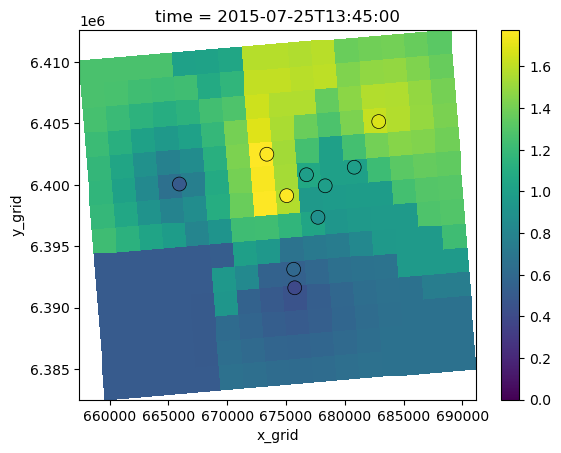

In [16]:
# Plot interpolated field
i = 3
plg.plot_map.plot_plg(
    da_grid=interpolate_ok.isel(time = t),
    da_gauges=da_gauges_municp_15min.isel(time = t),
    use_lon_lat=False,
    vmin=0,
    marker_size=100,
    cmap='viridis'
)

### Exercises ordinary kriging
1. What happens if you increase the range of the variogram
2. What happens if you increase the nugget of the variogram?
3. What happens if you set nnear to a low number? 

### Interpolate line data - Midpoint
We can interpolate CML data by using the midpoints of the CMLs as reference. 

In [17]:
# Treat CMLs as points
interpolator = mrg.interpolate.InterpolateOrdinaryKriging(min_observations = 1)

# Interpolate several timesteps
rainfall_field = []
for time in da_gauges_small.time.data:
    rainfall_field.append(
        # Interpolate 1 timestep
        interpolator.interpolate(
            da_grid=da_rad_small.sel(time = [time]), # Use radar grid coordinates for interpolation
            da_cml=da_cmls_small.sel(time = [time]),
            variogram_model = "spherical",
            variogram_parameters = {"sill": 1, "range": 8000, "nugget": 0},
            nnear=15,
            full_line=False, # Use the midpoint of the CML to esimtate distances
        )
    )

# Concat resulting fields
interpolate_okm = xr.concat(rainfall_field, dim="time")

<Axes: title={'center': 'time = 2015-07-25T13:45:00'}, xlabel='lon', ylabel='lat'>

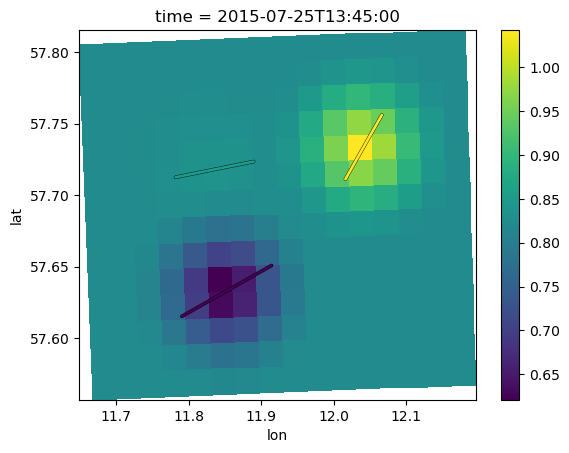

In [18]:
# Plot interpolated field
i = 3
plg.plot_map.plot_plg(
    da_grid=interpolate_okm.isel(time = t),
    da_cmls=da_cmls_small.isel(time = t),
    use_lon_lat=True,
    cmap='viridis',
)

### Interpolate line data - Full line
Mergeplg can also handle the full line integral of the CMLs using block kriging.

In [19]:
# Import interpolator
interpolator = mrg.interpolate.InterpolateOrdinaryKriging(
    min_observations = 1,
    discretization=8
)

# Interpolate several timesteps
rainfall_field = []
for time in da_gauges_small.time.data:
    rainfall_field.append(
        # Interpolate 1 timestepTrueTr
        interpolator.interpolate(
            da_grid=da_rad_small.sel(time = [time]), # Use radar grid coordinates for interpolation
            da_cml=da_cmls_small.sel(time = [time]),
            variogram_model = "spherical",
            variogram_parameters = {"sill": 1, "range": 5000, "nugget": 0},
            full_line=True
        )
    )

# Concat resulting fields
interpolate_okb = xr.concat(rainfall_field, dim="time")

<Axes: title={'center': 'time = 2015-07-25T13:45:00'}, xlabel='lon', ylabel='lat'>

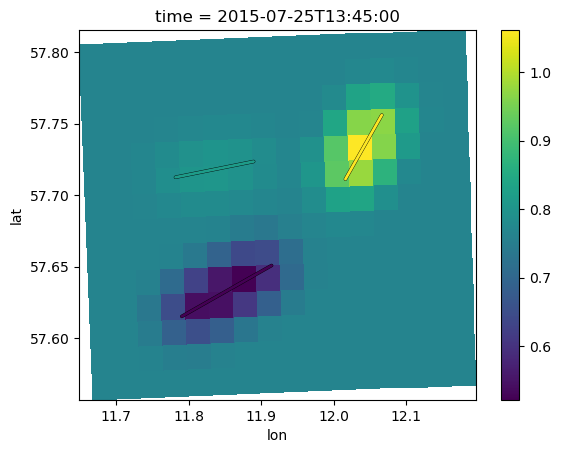

In [20]:
# Plot interpolated field
i = 3
plg.plot_map.plot_plg(
    da_grid=interpolate_okb.isel(time = t),
    da_cmls=da_cmls_small.isel(time = t),
    use_lon_lat=True,
    cmap='viridis',

)

## Interpolate lines and points

In [46]:
# Import interpolator
interpolator = mrg.interpolate.InterpolateOrdinaryKriging(min_observations = 1)

# Interpolate several timesteps
rainfall_field = []
for time in da_gauges_small.time.data:
    rainfall_field.append(
        # Interpolate 1 timestep
        interpolator.interpolate(
            da_grid=da_rad_small.sel(time = [time]), # Use radar grid coordinates for interpolation
            da_gauge=da_gauges_municp_15min.isel(time = t),
            da_cml=da_cmls_small.sel(time = [time]),
            variogram_model = "spherical",
            variogram_parameters = {"sill": 1, "range": 500, "nugget": 0},
            nnear=16,
            full_line = True
        )
    )

# Concat resulting fields
interpolate_okb_all = xr.concat(rainfall_field, dim="time")

<Axes: title={'center': 'time = 2015-07-25T13:45:00'}, xlabel='lon', ylabel='lat'>

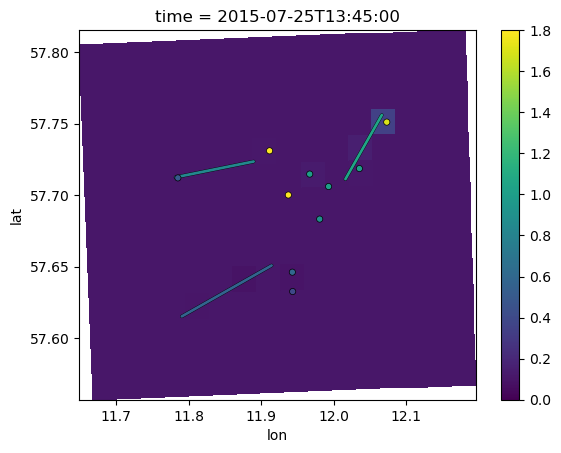

In [47]:
# Plot interpolated field
i = 3
plg.plot_map.plot_plg(
    da_grid=interpolate_okb_all.isel(time = t),
    da_cmls=da_cmls_small.isel(time = t),
    da_gauges=da_gauges_municp_15min.isel(time = t),
    use_lon_lat=True,
    vmin=0,
    vmax=1.8,
    cmap='viridis',
)

### Exercises block kriging
- What happens if you increase/decrease the range of the variogram?
- What happens if you increase/decrease the nugget value?
- Set the nugget to 0 and range to 10000.
    - What happens?
    - Try selecting gauge ".isel(id = [6])," and ".isel(cml_id = [0])", doe the situation improve?
    - Try using all rain gauges and CMLs, but increase the nugget value. Does this improve the solution?
    - Try using only the midpoints of the CMLs (full_line = False). Does this improve the situation?
    - Try setting nnear=4, does this improve the solution?
- Select longer links (in the code above), how strong is the CML averaging effect? 

# Extra

In [48]:
# Study a finer grid
gridsize = 200

# Create new grid with 1 km resolution
xmin = float(int(da_rad_small.x_grid.min()/gridsize)*gridsize)
xmax = float(int(da_rad_small.x_grid.max()/gridsize)*gridsize)
ymin = float(int(da_rad_small.y_grid.min()/gridsize)*gridsize)
ymax = float(int(da_rad_small.y_grid.max()/gridsize)*gridsize)

x_grid = np.arange(xmin, xmax + gridsize, gridsize)  # Ensure xmax is included
y_grid = np.arange(ymin, ymax + gridsize, gridsize)  # Ensure ymax is included
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)

da_grid_fine = xr.Dataset(
    data_vars=dict(
        precipitation=(["time", "y", "x"], np.zeros([da_rad_small.time.size, y_grid.size, x_grid.size])),
    ),
    coords=dict(
        x=x_grid,
        y=y_grid,
        x_grid=(["y", "x"], x_mesh),
        y_grid=(["y", "x"], y_mesh),
        time=da_rad_small.time,
    ),
)

In [ ]:
# Set low range, does this 

In [58]:
# Import interpolator
interpolator = mrg.interpolate.InterpolateOrdinaryKriging(
    min_observations = 1,
    discretization=3
)

# Interpolate several timesteps
rainfall_field = []
for time in da_gauges_small.time.data:
    rainfall_field.append(
        # Interpolate 1 timestepTrueTr
        interpolator.interpolate(
            da_grid=da_grid_fine.sel(time = [time]), # Use radar grid coordinates for interpolation
            da_cml=da_cmls_small.sel(time = [time]),
            da_gauge=da_gauges_small.sel(time = [time]),
            variogram_model = "exponential",
            variogram_parameters = {"sill": 1, "range": 100, "nugget": 0},
            nnear=16 
        )
    )

# Concat resulting fields
interpolate_okb_fine = xr.concat(rainfall_field, dim="time")

<Axes: title={'center': 'time = 2015-07-25T13:45:00'}, xlabel='x_grid', ylabel='y_grid'>

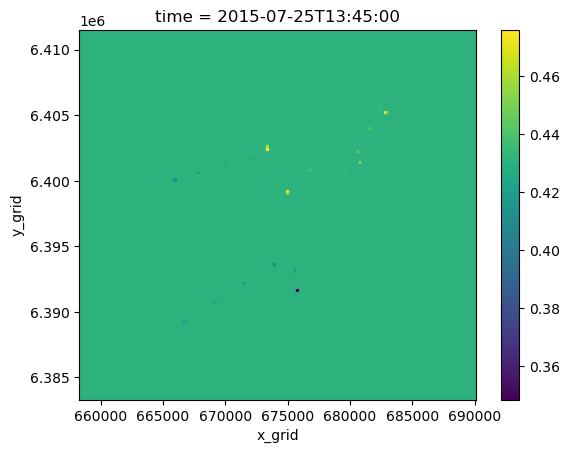

In [59]:
# Plot interpolated field
i = 3
plg.plot_map.plot_plg(
    da_grid=interpolate_okb_fine.isel(time = t),
    #da_cmls=da_cmls_small.isel(time = t),
    #da_gauges=da_gauges_municp_15min.isel(time = t),
    use_lon_lat=False,
    cmap='viridis',
    #vmin=0.5,
    #vmax = 1.8,
)